In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
data_folder = './data/'
pulse = np.loadtxt(data_folder + 'pule_shape.txt')
adc = np.loadtxt(data_folder + 'adc_out.txt')
signal = np.loadtxt(data_folder + 'signal.txt')
pileup = np.loadtxt(data_folder + 'pileup.txt')

of_coeff = np.loadtxt(data_folder + 'of_coeffs.txt')
of_out = np.loadtxt(data_folder + 'of_out.txt')

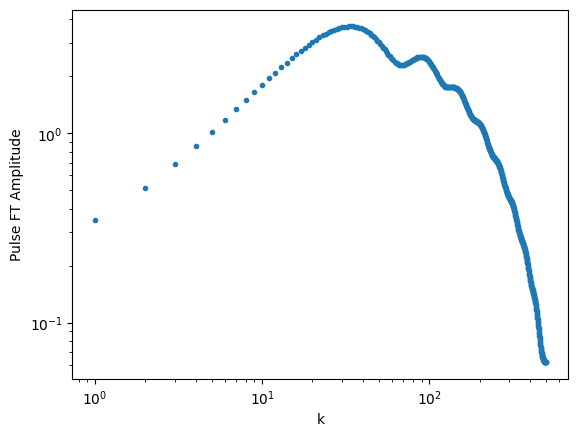

In [3]:
pp=np.zeros(1000)
pp[:len(pulse)]=pulse
ppft=np.fft.rfft(pp)
plt.clf()
plt.loglog(np.abs(ppft[1:]), '.')
plt.xlabel('k')
plt.ylabel('Pulse FT Amplitude')
plt.show()

In [4]:
npad=len(adc)-len(pileup)
signal=np.hstack([signal,np.zeros(npad)])
pileup=np.hstack([pileup,np.zeros(npad)])

In [5]:
pp=0*pileup
pp[:len(pulse)]=pulse

pred=np.fft.irfft(np.fft.rfft(pp)*np.fft.rfft(pileup+signal))

mypars=np.polyfit(adc[10000:-10000],pred[10000:-10000],1)
print('before rescaling, scatter is ',np.std((adc-pred)[10000:-10000]))
adc=adc*mypars[0]
sig=np.std((adc-pred)[10000:-10000])
print('after rescaling, scatter is ',sig) #np.std((adc-pred)[10000:-10000]))
N=sig**2
ideal_err=np.sqrt(N/np.sum(pp**2))
print('ideal err is ',ideal_err)

before rescaling, scatter is  0.16019129857925582
after rescaling, scatter is  0.0771519131819215
ideal err is  0.05245816383646302


In [6]:
def make_convmat(n,pulse):
    nn=len(pulse)
    mat=np.zeros([n,n+nn])
    for i in range(n):
        mat[i,i:i+nn]=pulse
    return mat


In [7]:
convmat=make_convmat(500,pulse).T
lhs=convmat.T@convmat
err_mat=np.linalg.inv(lhs/N)
deconv_err=np.median(np.sqrt(np.diag(err_mat)))
print('expected deconvolution error is ',deconv_err)

expected deconvolution error is  0.4222068882426552


optimal filter RMS  8.495495921936868


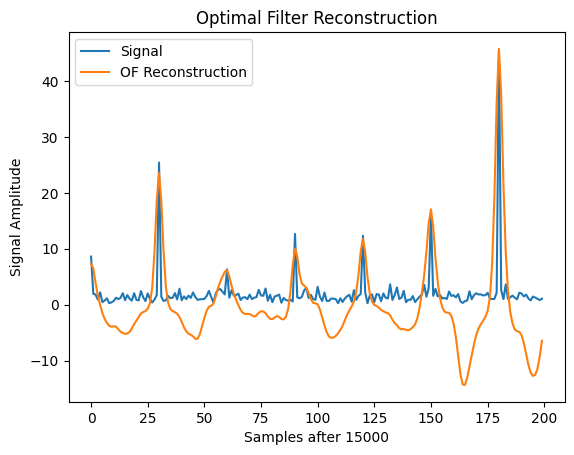

In [10]:
pp=np.roll(pp,0)

i1=15000
i2=i1+200
lhs=pp@pp
rhs=np.fft.irfft(np.fft.rfft(adc)*np.conj(np.fft.rfft(pp)))
ofilt=rhs/lhs
oerr=signal+pileup-ofilt
print('optimal filter RMS ',np.std(oerr[10000:-10000]))
plt.clf()
plt.plot((signal+pileup)[i1:i2])
plt.plot(ofilt[i1:i2])
plt.xlabel('Samples after '+repr(i1))
plt.legend(['Signal','OF Reconstruction'])
plt.ylabel('Signal Amplitude')
plt.title('Optimal Filter Reconstruction')
plt.show()

deconvolution RMS  0.3736432627336601


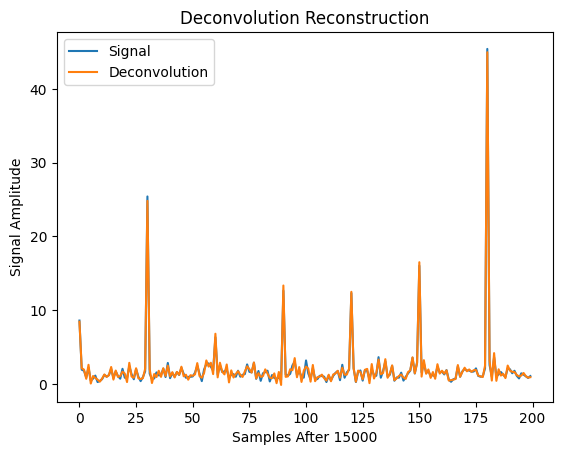

In [11]:
deconv=np.fft.irfft(np.fft.rfft(adc)/np.fft.rfft(pp))
#plt.plot(deconv[i1:i2])
derr=signal+pileup-deconv
print('deconvolution RMS ',np.std(derr[10000:-10000]))
plt.clf()
plt.plot((signal+pileup)[i1:i2])
plt.plot(deconv[i1:i2])
plt.xlabel('Samples After '+repr(i1))
plt.ylabel('Signal Amplitude')
plt.title('Deconvolution Reconstruction')
plt.legend(['Signal','Deconvolution'])
plt.show()

bayes RMS  0.3263093681459874


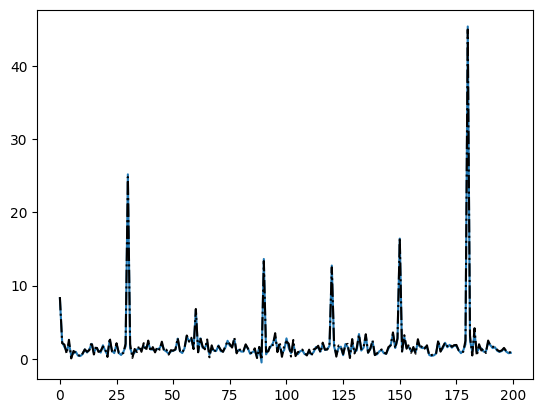

In [35]:
maxent=np.load('./data/maxent_fit_'+repr(i1)+'.npy')

#plt.plot((signal+pileup)[i1:i2])
plt.plot(maxent[:(i2-i1)])
plt.plot(deconv[i1:i2], 'k-.')
enterr=(signal+pileup)[i1:i1+len(maxent)]-maxent

print('bayes RMS ',np.std(enterr))

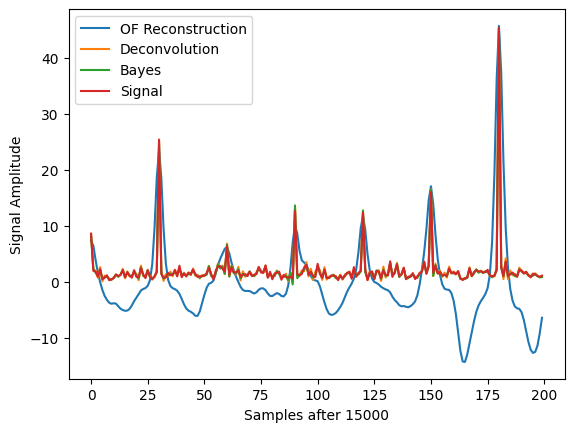

In [13]:

plt.plot(ofilt[i1:i2])
plt.plot(deconv[i1:i2])
plt.plot(maxent[:(i2-i1)])
plt.plot((signal+pileup)[i1:i2])
plt.legend(['OF Reconstruction','Deconvolution','Bayes','Signal'])
plt.xlabel('Samples after '+repr(i1))
#plt.legend(['Signal','OF Reconstruction'])
plt.ylabel('Signal Amplitude')
plt.show()

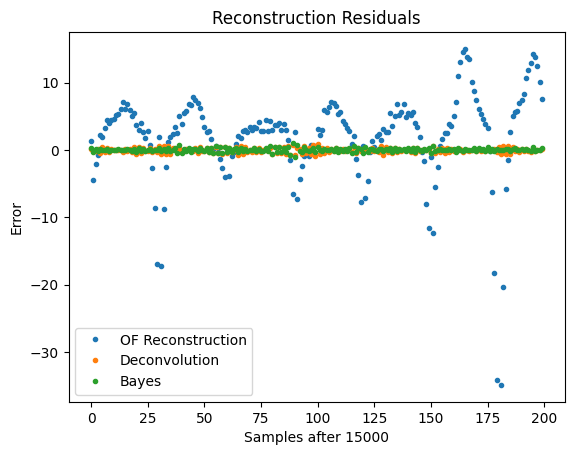

In [24]:
plt.plot(oerr[i1:i2],'.')
plt.plot(derr[i1:i2],'.')
plt.plot(enterr[:i2-i1],'.')
plt.xlabel('Samples after '+repr(i1))
plt.ylabel('Error')
plt.legend(['OF Reconstruction','Deconvolution','Bayes'])
plt.title('Reconstruction Residuals')
plt.show()

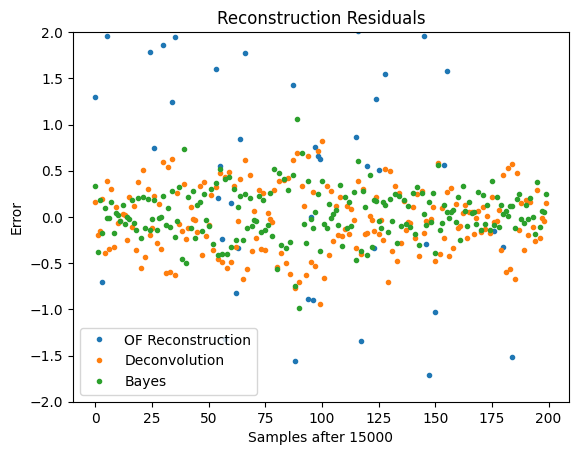

In [23]:
plt.plot(oerr[i1:i2],'.')
plt.plot(derr[i1:i2],'.')
plt.plot(enterr[:i2-i1],'.')
plt.xlabel('Samples after '+repr(i1))
plt.ylabel('Error')
plt.legend(['OF Reconstruction','Deconvolution','Bayes'])
plt.title('Reconstruction Residuals')

plt.ylim([-2,2])
plt.show()

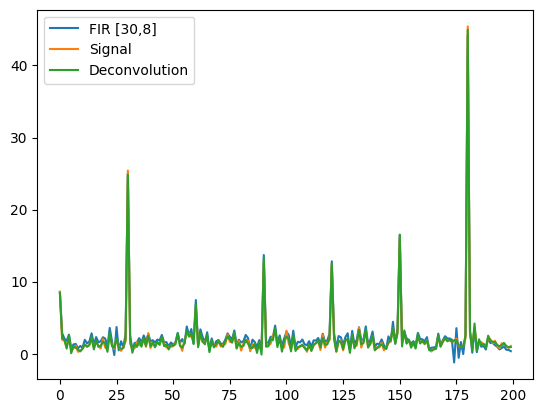

linear RMS is  0.7164750246992455


In [25]:
jl=30
jr=8
k1=10000
k2=len(adc)-k1
D=np.zeros([k2-k1,jl+jr+2])
D[:,0]=1  #we'll add an overall offset as a fit parameter
for i in range(k1,k2):
    D[i-k1,1:]=adc[i-jl:i+jr+1]
s=(signal+pileup)[k1:k2]
c=np.linalg.inv(D.T@D)@(D.T@s)
pred=D@c
plt.clf();
plt.plot(pred[i1-k1:i2-k1]);
plt.plot(s[i1-k1:i2-k1]);
plt.plot(deconv[i1:i2])

plt.legend(['FIR ['+repr(jl)+','+repr(jr)+']','Signal','Deconvolution'])
plt.show()
print('linear RMS is ',np.std(pred-s))

nonlinear RMS is  0.33015096710609354


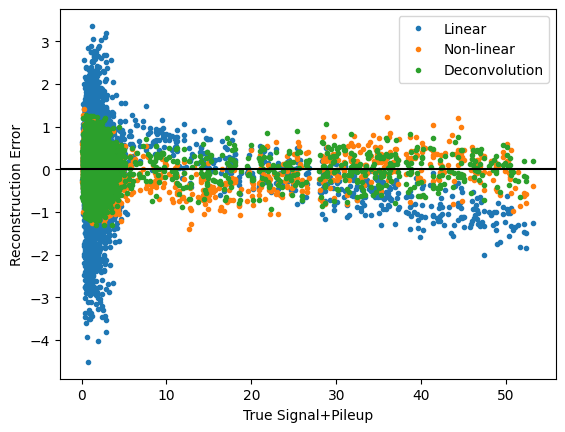

In [26]:
DD=np.hstack([D,D[:,1:]**2,D[:,1:]**3]);npow=3
cc=np.linalg.inv(DD.T@DD)@(DD.T@s)
pp=DD@cc
print('nonlinear RMS is ',np.std(pp-s))

nplot=15000
plt.clf()
plt.plot(s[k1:k1+nplot],(pred-s)[k1:k1+nplot],'.')
plt.plot(s[k1:k1+nplot],(pp-s)[k1:k1+nplot],'.')
plt.plot(s[k1:k1+nplot],deconv[2*k1:2*k1+nplot]-s[k1:k1+nplot],'.')
plt.legend(['Linear','Non-linear','Deconvolution'])
xx=plt.xlim()
plt.plot(xx,[0,0],'k')
plt.xlim(xx)
plt.xlabel('True Signal+Pileup')
plt.ylabel('Reconstruction Error')
plt.show()

In [28]:
#let's fit residuals to a stretch where the
#nonlinear seems to be missing for (25,6) filter
if 0:
    smin=7
    smax=26
    mask=(pp>smin)&(pp<smax)
    fitp=np.polyfit(pp[mask],(pp-s)[mask],2)
    pp2=pp.copy()
    pp2[mask]=pp2[mask]-np.polyval(fitp,pp[mask])
    plt.plot(s[k1:k1+nplot],(pp2-s)[k1:k1+nplot],'.')

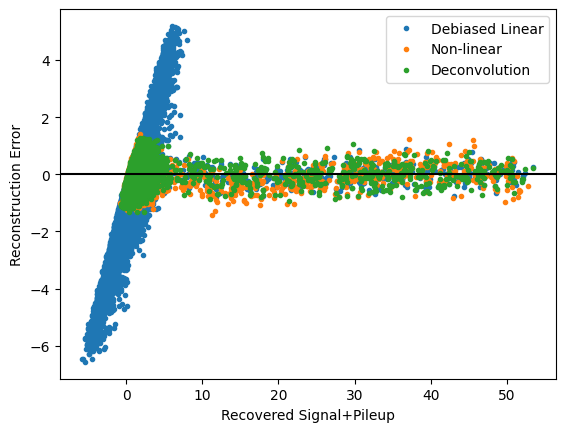

In [29]:
sthresh=10
mask=s>sthresh
D2=D[mask,:]
s2=s[mask]
c2=np.linalg.inv(D2.T@D2)@(D2.T@s2)
pred2=D@c2

plt.plot(pred2[k1:k1+nplot],(pred2-s)[k1:k1+nplot],'.')
plt.plot(pp[k1:k1+nplot],(pp-s)[k1:k1+nplot],'.')
plt.plot(deconv[2*k1:2*k1+nplot],deconv[2*k1:2*k1+nplot]-s[k1:k1+nplot],'.')

plt.legend(['Debiased Linear','Non-linear','Deconvolution'])
xx=plt.xlim()
yl=plt.ylim()
plt.plot(xx,[0,0],'k')
plt.xlim(xx)
plt.xlabel('Recovered Signal+Pileup')
plt.ylabel('Reconstruction Error')
plt.show()

high-energy scatter:  0.30296142071517257


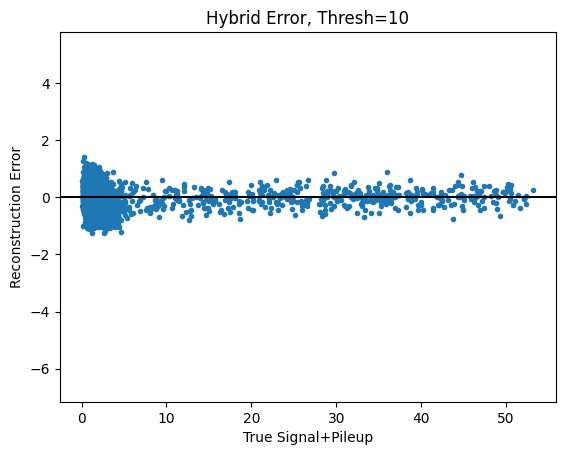

In [30]:
thresh=10
mask=pred2>thresh
best_pp=pp.copy() #the nonlinear FIR
best_pp[mask]=pred2[mask]
print('high-energy scatter: ',np.std((best_pp-s)[mask]))

plt.plot(s[k1:k1+nplot],(best_pp-s)[k1:k1+nplot],'.')

#plt.legend(['Debiased Linear','Non-linear','Deconvolution'])
xx=plt.xlim()
plt.plot(xx,[0,0],'k')
plt.xlim(xx)
plt.xlabel('True Signal+Pileup')
plt.ylabel('Reconstruction Error')
plt.ylim(yl)
plt.title('Hybrid Error, Thresh='+repr(thresh))

plt.show()

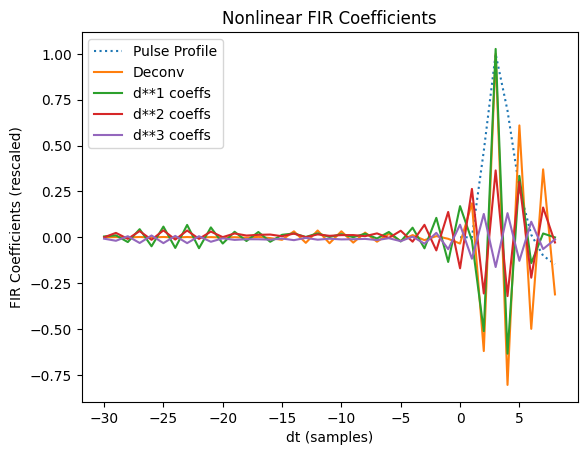

In [31]:
plt.clf()
nplot=300
fac=3
plt.plot(s[k1:k1+nplot])
plt.plot(fac*(best_pp-s)[k1:k1+nplot])
plt.legend(['True Signal+Pileup',repr(fac)+'*reconstruction Error'])
xx=plt.xlim()
plt.plot(xx,[0,0],'k')
plt.xlim(xx)


nn=(len(cc)-1)//npow
cc_rect=np.empty([nn,npow])
for i in range(npow):
    cc_rect[:,i]=cc[1+i*nn:1+(i+1)*nn]*(50**i)/2
plt.clf()
plt.plot(np.arange(jr+1),pulse[:jr+1],':')
pvec=0*s
pvec[:len(pulse)]=pulse
pft=np.fft.rfft(pvec)
pcoeffs=np.fft.irfft(1/np.conj(pft))
pcoeffs=pcoeffs/pcoeffs.max()
to_plot=np.zeros(jl+jr+1)
to_plot[:jl]=pcoeffs[-jl:]
to_plot[jl:]=pcoeffs[:jr+1]
plt.plot(np.arange(-jl,jr+1),to_plot)

plt.plot(np.arange(-jl,jr+1),cc_rect)



myleg=['Pulse Profile','Deconv']
for i in range(npow):
    myleg=myleg+['d**'+repr(i+1)+' coeffs']
plt.legend(myleg)
plt.title('Nonlinear FIR Coefficients')
plt.xlabel('dt (samples)')
plt.ylabel('FIR Coefficients (rescaled)')
plt.show()

In [32]:
mask=s<sthresh
DD2=DD[mask,:]
ss=s[mask]
cc2=np.linalg.inv(DD2.T@DD2)@(DD2.T@ss)

pp2=DD@cc2
ptot=pred2
ptot[mask]=pp2[mask]

ptot

array([3.09706277, 1.49602404, 0.50629176, ..., 1.2898125 , 0.48164769,
       1.19476686])